# Get the data

In [55]:
import pandas as pd
train_set=pd.read_csv('anotherdataset/train.csv')
test_set=pd.read_csv('anotherdataset/test.csv')

In [56]:
#快速查看数据结构
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 探索性数据分析

In [57]:
import matplotlib.pyplot as plt
train_set.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

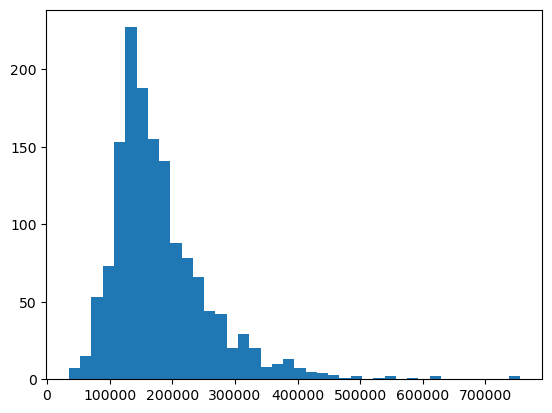

In [58]:
#价格分布
SalePrice=train_set['SalePrice'].values
plt.hist(SalePrice, bins=40)
plt.show()

In [59]:
#查看训练数据属性
train_set.dtypes.value_counts()

object     43
int64      35
float64     3
Name: count, dtype: int64

In [60]:
#把训练集分成数值类型和类别类型
train_set_cat = train_set.select_dtypes(include='object')
train_set_cat['SalePrice'] = train_set['SalePrice']
train_set_num = train_set.select_dtypes(include='number')
train_set_num['SalePrice'] = train_set['SalePrice']

In [61]:
#方差分析
from scipy.stats import f_oneway
def ANOVA(df, feature):
    category_groups = df.groupby(feature)['SalePrice'].apply(list)
    return f_oneway(*category_groups)

In [62]:
p_vals = {}
for col in train_set_cat.columns:
    p_vals[col] = ANOVA(train_set_cat, col).statistic
p_vals.pop('SalePrice')

d:\Anaconda\lib\site-packages\scipy\stats\stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


inf

In [63]:
#最先查看前十个影响因子，后面选取不同的数量比较了一下训练效果，最后选取了30个
cat_features=sorted(p_vals, key=p_vals.get, reverse=True)[:30]

In [64]:
#皮尔逊相关系数
corr = train_set_num.corr(method='pearson')
corr = corr.SalePrice.apply(abs).to_dict()
corr.pop('SalePrice')
num_fetures=sorted(corr, key=corr.get, reverse=True)[:30]

In [65]:
features = cat_features+num_fetures
train_set[features].head(5)

,ExterQual,KitchenQual,BsmtQual,GarageFinish,Foundation,CentralAir,HeatingQC,Neighborhood,GarageType,BsmtExposure,...,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,MoSold
0,Gd,Gd,Gd,RFn,PConc,Y,Ex,CollgCr,Attchd,No,...,1,150,3,1,0,0,0,60,5,2
1,TA,TA,Gd,RFn,CBlock,Y,Ex,Veenker,Attchd,Gd,...,0,284,3,1,0,0,0,20,8,5
2,Gd,Gd,Gd,RFn,PConc,Y,Ex,CollgCr,Attchd,Mn,...,1,434,3,1,0,0,0,60,5,9
3,TA,Gd,TA,Unf,BrkTil,Y,Gd,Crawfor,Detchd,No,...,1,540,3,1,272,0,0,70,5,2
4,Gd,Gd,Gd,RFn,PConc,Y,Ex,NoRidge,Attchd,Av,...,1,490,4,1,0,0,0,60,5,12


# 数据预处理

In [66]:
from sklearn.model_selection import  train_test_split
X = train_set[features].loc[:, train_set[features].columns != "SalePrice"]
y = train_set['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [67]:
#标准化数据
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalizedVars = scaler.fit_transform(X_train[num_fetures])
normalizedVars_df = pd.DataFrame(normalizedVars, columns=scaler.get_feature_names_out())
normalizedVars_df=normalizedVars_df.fillna(0)
normalizedVars_df.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,MoSold
0,0.637073,-0.051643,0.293831,-0.192617,0.642893,0.862092,0.772872,0.268177,1.107889,1.020374,...,-0.813995,1.711873,-1.112669,-0.207743,-0.344584,-0.280154,-0.073333,1.475911,-0.515364,-0.508139
1,-0.094926,-0.421692,0.293831,0.030695,-0.046799,0.357895,-1.062909,-0.963076,0.094543,0.682585,...,1.119464,-1.279161,0.128036,-0.207743,-0.344584,-0.280154,15.000378,-0.871228,0.390453,-2.000860
2,-0.094926,-0.518474,-1.069494,-0.938576,-1.128667,-1.221922,-1.062909,-0.347450,-1.049557,-1.681937,...,-0.813995,-0.478553,-1.112669,-0.207743,-0.344584,-0.280154,-0.073333,-0.167086,-0.515364,1.357763
3,-0.826925,-0.207253,-1.069494,-0.910068,-0.186540,0.650071,-1.062909,-0.347450,-0.363097,-0.330782,...,-0.813995,0.920261,0.128036,-0.207743,0.242811,-0.280154,-0.073333,-0.871228,-0.515364,0.611402
4,-0.094926,-0.169300,-1.069494,-0.838798,0.859266,0.701784,-1.062909,0.268177,-0.428474,-1.295893,...,-0.813995,0.596420,1.368742,-0.207743,4.142457,-0.280154,-0.073333,-0.871228,0.390453,-0.881319


In [68]:
#独热编码
from sklearn.preprocessing import OneHotEncoder 
enc = OneHotEncoder(handle_unknown='ignore')
categoricalVars = enc.fit_transform(X_train[cat_features]).toarray()
categoricalVars_df = pd.DataFrame(categoricalVars, columns=enc.get_feature_names_out())
categoricalVars_df=categoricalVars_df.fillna(0.0)  #在这里用0.0填充了缺失值
categoricalVars_df.head()


,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [69]:
#合并数据
X_train_cleaned = pd.concat([categoricalVars_df, normalizedVars_df], axis='columns')
X_train_cleaned.head()

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,MoSold
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.813995,1.711873,-1.112669,-0.207743,-0.344584,-0.280154,-0.073333,1.475911,-0.515364,-0.508139
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.119464,-1.279161,0.128036,-0.207743,-0.344584,-0.280154,15.000378,-0.871228,0.390453,-2.000860
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,-0.478553,-1.112669,-0.207743,-0.344584,-0.280154,-0.073333,-0.167086,-0.515364,1.357763
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,0.920261,0.128036,-0.207743,0.242811,-0.280154,-0.073333,-0.871228,-0.515364,0.611402
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,0.596420,1.368742,-0.207743,4.142457,-0.280154,-0.073333,-0.871228,0.390453,-0.881319


In [70]:
#按一样的步骤操作测试集
X_test_categorical = enc.transform(X_test[cat_features]).toarray()
X_test_categorical_df = pd.DataFrame(X_test_categorical, columns = enc.get_feature_names_out())
X_test_categorical_df=X_test_categorical_df.fillna(0)
X_test_normalized = scaler.transform(X_test[num_fetures])
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=scaler.get_feature_names_out())
X_test_normalized_df=X_test_normalized_df.fillna(0.0)
X_test_cleaned = pd.concat([X_test_categorical_df, X_test_normalized_df], axis='columns')
X_test_cleaned.head()

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,MoSold
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,-0.388597,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,-0.871228,2.202087,-1.627680
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.119464,-0.309886,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,0.067628,-0.515364,-0.881319
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,0.987728,-1.112669,-0.207743,1.776563,-0.280154,-0.073333,-0.636514,0.390453,-1.254499
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,0.081422,0.128036,-0.207743,0.242811,-0.280154,-0.073333,-0.167086,1.296270,1.357763
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.119464,0.065680,-1.112669,-0.207743,-0.344584,-0.280154,-0.073333,-0.871228,-0.515364,0.984583


# 模型训练

In [71]:
#使用线性回归但是效果并不好
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_cleaned, y_train)
y_pred_train = lin_reg.predict(X_train_cleaned)
y_pred_test = lin_reg.predict(X_test_cleaned)
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))


Train RMSE: 25651.792624444177
Test RMSE: 1.4910694240727272e+16


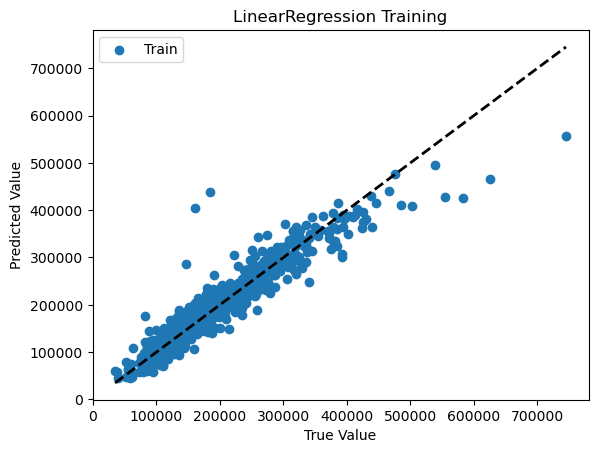

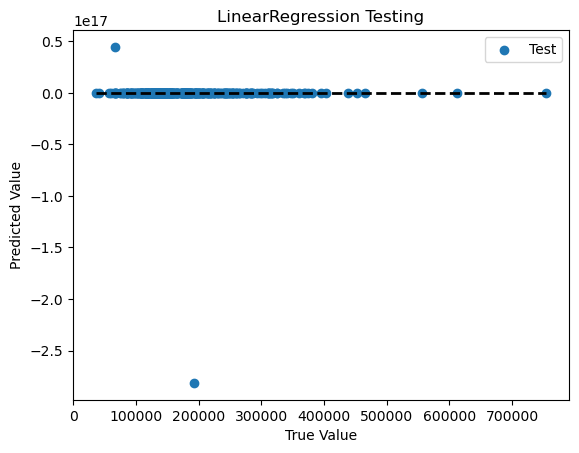

In [72]:
#训练结果可视化
# 绘制训练集的预测值与真实值关系  
plt.scatter(y_train, y_pred_train, label='Train')  
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('LinearRegression Training')  
plt.legend()  
plt.show()  
  
# 绘制测试集的预测值与真实值关系  
plt.scatter(y_test, y_pred_test, label='Test')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('LinearRegression Testing')  
plt.legend()  
plt.show()

In [73]:
#选用SGDRegressor效果好了很多
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
sgd = SGDRegressor(loss="squared_error", fit_intercept=True, learning_rate='invscaling', eta0=0.01)  
train_rmse_list=[]
test_rmse_list=[]
best_train_rmse = np.inf  # 初始化最佳RMSE为无穷大 
best_test_rmse=np.inf 
best_model = None  # 初始化最佳模型为None 
for epoch in range(100):  # 假设我们训练100个epoch  
    sgd.fit(X_train_cleaned, y_train)
    y_pred_train = sgd.predict(X_train_cleaned)
    y_pred_test = sgd.predict(X_test_cleaned)
    train_rmse=mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse=mean_squared_error(y_test, y_pred_test, squared=False)
    train_rmse_list.append(train_rmse)  
    test_rmse_list.append(test_rmse) 
     # 检查当前轮次的RMSE是否小于之前最好的RMSE  
    if train_rmse < best_train_rmse:  
        best_train_rmse = train_rmse 
        best_model = sgd  # 更新最佳模型  
    if test_rmse < best_test_rmse:  
        best_test_rmse = train_rmse 
# 输出最佳RMSE和最佳模型  
print("Best train RMSE:", best_train_rmse)  
print("Best test RMSE:", best_test_rmse)  

#由此指标可以看出模型具有较好的泛化能力

Best train RMSE: 26809.43386451981
Best test RMSE: 27833.453848078145


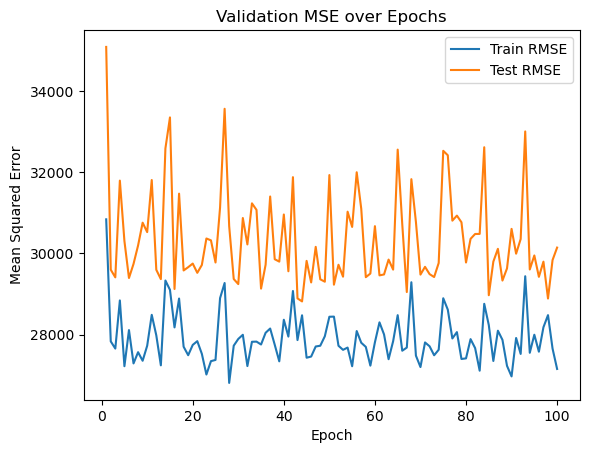

In [74]:
#训练过程可视化
# 初始化图形  
fig, ax = plt.subplots()  
# 在同一张图上绘制训练集和测试集的RMSE  
ax.plot(range(1, 101), train_rmse_list, label='Train RMSE')  
ax.plot(range(1, 101), test_rmse_list, label='Test RMSE')    
# 设置图形的标题和X、Y轴标签  
ax.set_title('Validation MSE over Epochs')  
ax.set_xlabel('Epoch')  
ax.set_ylabel('Mean Squared Error')  
# 显示图例  
ax.legend()  
# 显示图形  
plt.show()



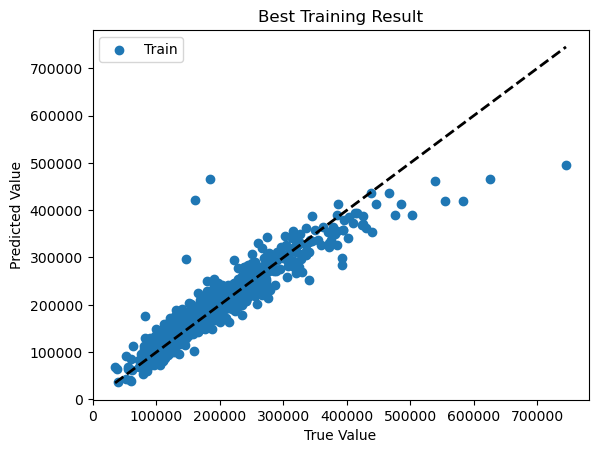

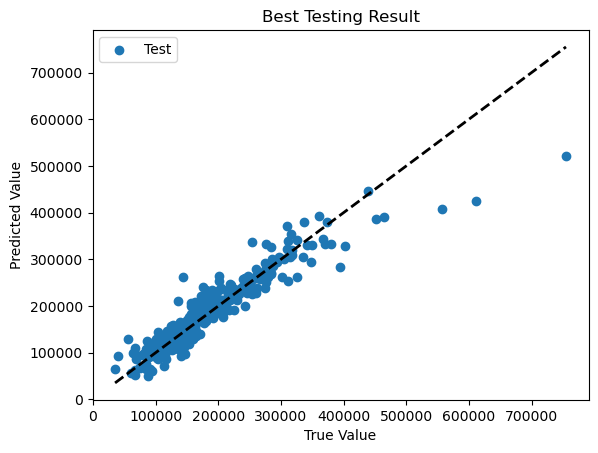

In [75]:
#最佳训练结果可视化
y_pred_train = sgd.predict(X_train_cleaned)
y_pred_test = sgd.predict(X_test_cleaned)
# 绘制训练集的预测值与真实值关系  
plt.scatter(y_train, y_pred_train, label='Train')  
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('Best Training Result')  
plt.legend()  
plt.show()  
  
# 绘制测试集的预测值与真实值关系  
plt.scatter(y_test, y_pred_test, label='Test')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('Best Testing Result')  
plt.legend()  
plt.show()

# 研究选取不同的训练集对训练结果的影响


In [76]:
# 经过对43个类别型和38个数值型数据组合的训练结果的考察，我猜想训练结果和两者的组合方式存在一定联系。我想要通过枚举法找到使训练结果最佳的组合方式。但是最后并没有成功

# from mpl_toolkits.mplot3d import Axes3D  
# import matplotlib.pyplot as plt 
# import numpy as np
# min_train_rmse = float('inf')
# best_x, best_y = None, None
# Z=[]
# for x in range(1,39):
#   normalizedVars_df= normalizedVars_df.iloc[:, :x]
#   X_test_normalized_df=X_test_normalized_df.iloc[:,:x]
#   for y in range(1,44):
#       categoricalVars_df=categoricalVars_df.iloc[:, :y] 
#       X_test_categorical_df=X_test_categorical_df.iloc[:, :y] 
#       X_train_cleaned = pd.concat([categoricalVars_df, normalizedVars_df], axis='columns')
#       X_test_cleaned = pd.concat([X_test_categorical_df, X_test_normalized_df], axis='columns')
#       y_pred_train = sgd.predict(X_train_cleaned)
#       y_pred_test = sgd.predict(X_test_cleaned)
#       TestRMSE=mean_squared_error(y_test, y_pred_test, squared=False)
#       trainRMSE=mean_squared_error(y_train,y_pred_train)
#       Z.append(trainRMSE)
#        # Check if the current TestRMSE is smaller than the minimum recorded TestRMSE
#       if trainRMSE < min_test_rmse:
#             min_test_rmse = TestRMSE
#             best_x, best_y = x, y




# 预测房价

In [77]:
test_features = [feature for feature in features if feature != 'SalePrice']
X_test_df = test_set[test_features]
X_test_categorical = enc.transform(X_test_df[cat_features]).toarray()
X_test_categorical_df = pd.DataFrame(X_test_categorical, columns = enc.get_feature_names_out())
X_test_normalized = scaler.transform(X_test_df[num_fetures])
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=scaler.get_feature_names_out())
X_test_cleaned = pd.concat([X_test_categorical_df, X_test_normalized_df], axis='columns')
X_test_cleaned

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,MoSold
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,-0.671958,-1.112669,-0.207743,-0.344584,1.831848,-0.073333,-0.871228,0.390453,-0.134958
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.813995,-0.366108,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,-0.871228,0.390453,-0.134958
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,-0.971062,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,0.067628,-0.515364,-1.254499
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.813995,-0.550518,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,0.067628,0.390453,-0.134958
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.813995,1.007968,-1.112669,-0.207743,-0.344584,2.254248,-0.073333,1.475911,-0.515364,-2.000860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,-0.051263,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,2.414766,1.296270,-0.134958
1455,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,-0.617985,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,2.414766,-0.515364,-0.881319
1456,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.119464,-1.279161,1.368742,-0.207743,-0.344584,-0.280154,-0.073333,-0.871228,1.296270,0.984583
1457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.813995,0.013955,0.128036,-0.207743,-0.344584,-0.280154,-0.073333,0.654412,-0.515364,0.238222


In [78]:
#处理缺失值
X_test_cleaned.isnull().sum().sum()
X_test_cleaned[X_test_cleaned['TotalBsmtSF'].isnull()]
X_test_cleaned[X_test_cleaned['GarageArea'].isnull()]
X_test_cleaned[X_test_cleaned['GarageCars'].isnull()]
X_test_cleaned = X_test_cleaned.fillna(0)

In [79]:
y_pred_lr = sgd.predict(X_test_cleaned)

In [80]:
final_df = pd.DataFrame()
final_df['Id'] = test_set['Id'].values
final_df['SalePrice'] = y_pred_lr
final_df.head(5)

,Id,SalePrice
0,1461,113079.165898
1,1462,152514.273264
2,1463,168448.910324
3,1464,183701.925946
4,1465,219141.751285


In [81]:
#写入提交文件
final_df.to_csv('anotherdataset/submission.csv', index=False)


# 提交结果
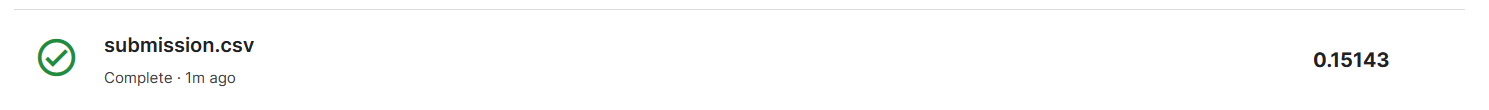